In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
%load_ext autoreload
%autoreload 2

In [2]:
function_df = pd.read_csv('Kka2/Kka2.txt')

In [3]:
function_df.head()

,protein,uniprot,dms_id,position,aa1,aa2,predicted?,predictions,sequence
0,Kka2,P00552,kka2_1:2,62,D,Q,NO,-0.382303,MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
1,Kka2,P00552,kka2_1:2,19,L,H,NO,-0.232793,MIEQDGLHAGSPAAWVERHFGYDWAQQTIGCSDAAVFRLSAQGRPV...
2,Kka2,P00552,kka2_1:2,77,C,N,NO,-0.132649,MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
3,Kka2,P00552,kka2_1:2,78,A,W,NO,-0.124879,MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
4,Kka2,P00552,kka2_1:2,187,T,P,NO,-0.075618,MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...


In [4]:
function_df['sequence_len'] = function_df['sequence'].apply(lambda seq: len(seq)) 
max_len = function_df['sequence_len'].max()

In [5]:
def sequence_to_aa(seq):
  return list(seq)

In [6]:
def get_sequence_aa(df):
  df['sequence_aa'] = df['sequence'].apply(lambda seq:sequence_to_aa(seq))
  df['length'] = df['sequence'].apply(lambda seq:len(seq))
  sequence_aa = np.array(df['sequence_aa'])
  return sequence_aa

In [7]:
sequence_aa = get_sequence_aa(function_df)

In [8]:
# import neccesary tools from Keras
import keras
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

Using TensorFlow backend.


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequence_aa)
encoded = tokenizer.texts_to_sequences(sequence_aa)
vocab_len = len(tokenizer.word_index) + 1

In [10]:
X = np.array(encoded)
y = function_df['predictions']

from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1)

In [11]:
y_train.mean()

0.698958515091104

In [12]:
from keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization, Softmax, multiply, Lambda, Flatten, Activation, RepeatVector, Permute, LeakyReLU
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.initializers import Constant

# from fit_one_cycle.clr import LRFinder

In [23]:
LSTM_size = 10
dense_sizes = [16]
LSTM_dropout = 0.0
n_epochs = 1500
adam_lr = [0.003]
initializers = ['he_uniform']

In [14]:
def get_model_LSTM(initializer, LSTM_size):
    input = Input(shape = [max_len])
    embedding = Embedding(input_dim = vocab_len, 
                          output_dim = 20, 
                          input_length = max_len, 
                          trainable = True)(input)

    activations = LSTM(LSTM_size,
                       dropout = LSTM_dropout,
                       kernel_initializer = initializer)(embedding)

    sequence_representation = Dense(16, kernel_initializer = initializer)(activations)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)
    sequence_representation = Dense(8, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)

    output = Dense(1, bias_initializer = Constant(y_train.mean()))(sequence_representation)

    model = Model(inputs = [input], outputs = output)
    return model

In [15]:
def get_model_LSTM_attention(initializer, LSTM_size):
    input = Input(shape = [max_len])
    embedding = Embedding(input_dim = vocab_len, 
                          output_dim = 20, 
                          input_length = max_len, 
                          trainable = True)(input)

    activations = LSTM(LSTM_size, return_sequences = True,
                       dropout = LSTM_dropout,
                       kernel_initializer = initializer)(embedding)

    attention = Dense(1, activation = 'tanh', kernel_initializer = initializer)(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax', name = 'attention_activations')(attention)
    attention = RepeatVector(LSTM_size)(attention)
    attention = Permute([2, 1])(attention)

    sequence_representation = multiply([activations, attention])
    sequence_representation = Lambda(lambda xin: K.sum(xin, axis = -2), output_shape = (LSTM_size,))(sequence_representation)
    
    sequence_representation = Dense(16, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)
    sequence_representation = Dense(8, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)

    output = Dense(1, bias_initializer = Constant(y_train.mean()))(sequence_representation)

    model = Model(inputs = [input], outputs = output)
    return model

In [16]:
def get_model_biLSTM_attention(initializer, LSTM_size):
    input = Input(shape = [max_len])
    embedding = Embedding(input_dim = vocab_len, 
                          output_dim = 20, 
                          input_length = max_len, 
                          trainable = True)(input)

    activations = Bidirectional(LSTM(LSTM_size, return_sequences = True,
                       dropout = LSTM_dropout,
                       kernel_initializer = initializer))(embedding)

    attention = Dense(1, activation = 'tanh', kernel_initializer = initializer)(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax', name = 'attention_activations')(attention)
    attention = RepeatVector(LSTM_size * 2)(attention)
    attention = Permute([2, 1])(attention)

    sequence_representation = multiply([activations, attention])
    sequence_representation = Lambda(lambda xin: K.sum(xin, axis = -2), output_shape = (LSTM_size * 2,))(sequence_representation)
    
    sequence_representation = Dense(16, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)
    sequence_representation = Dense(8, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)

    output = Dense(1, bias_initializer = Constant(y_train.mean()))(sequence_representation)

    model = Model(inputs = [input], outputs = output)
    return model

adam_lr - 0.001 initializer - he_uniform
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3238 samples, validate on 360 samples
Epoch 1/1000
3238/3238 [==============================] - 32s 10ms/step - loss: 0.1546 - val_loss: 0.1517
Epoch 2/1000
3238/3238 [==============================] - 18s 6ms/step - loss: 0.1544 - val_loss: 0.1517
Epoch 3/1000
3238/3238 [==============================] - 17s 5ms/step - loss: 0.1543 - val_loss: 0.1517
Epoch 4/1000
3238/3238 [==============================] - 10s 3ms/step - loss: 0.1544 - val_loss: 0.1517
Epoch 5/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1517
Epoch 6/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1517
Epoch 7/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1517
Epoch 8/1000
3238/3238 [==============================] - 1

Epoch 73/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1517
Epoch 74/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1517
Epoch 75/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 76/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1517
Epoch 77/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1516
Epoch 78/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1517
Epoch 79/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1517
Epoch 80/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 81/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 82/1000
3238/3238 [==============================

3238/3238 [==============================] - 8s 3ms/step - loss: 0.1543 - val_loss: 0.1517
Epoch 151/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 152/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 153/1000
3238/3238 [==============================] - 8s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 154/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1518
Epoch 155/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1516
Epoch 156/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1516
Epoch 157/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 158/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 159/1000
3238/3238 [==============================] - 8

3238/3238 [==============================] - 9s 3ms/step - loss: 0.1542 - val_loss: 0.1516
Epoch 228/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1543 - val_loss: 0.1516
Epoch 229/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1542 - val_loss: 0.1515
Epoch 230/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1542 - val_loss: 0.1514
Epoch 231/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1541 - val_loss: 0.1515
Epoch 232/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1515
Epoch 233/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1540 - val_loss: 0.1517
Epoch 234/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1515
Epoch 235/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1540 - val_loss: 0.1518
Epoch 236/1000
3238/3238 [==============================] - 9

3238/3238 [==============================] - 9s 3ms/step - loss: 0.1528 - val_loss: 0.1535
Epoch 305/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1544 - val_loss: 0.1501
Epoch 306/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1532 - val_loss: 0.1501
Epoch 307/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1530 - val_loss: 0.1504
Epoch 308/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1527 - val_loss: 0.1500
Epoch 309/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1528 - val_loss: 0.1499
Epoch 310/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1522 - val_loss: 0.1515
Epoch 311/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1537 - val_loss: 0.1497
Epoch 312/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1521 - val_loss: 0.1502
Epoch 313/1000
3238/3238 [==============================] - 9

3238/3238 [==============================] - 9s 3ms/step - loss: 0.1512 - val_loss: 0.1477
Epoch 382/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1495 - val_loss: 0.1510
Epoch 383/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1509 - val_loss: 0.1499
Epoch 384/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1503 - val_loss: 0.1478
Epoch 385/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1500 - val_loss: 0.1476
Epoch 386/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1490 - val_loss: 0.1472
Epoch 387/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1491 - val_loss: 0.1477
Epoch 388/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1514 - val_loss: 0.1592
Epoch 389/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1552 - val_loss: 0.1473
Epoch 390/1000
3238/3238 [==============================] - 1

3238/3238 [==============================] - 10s 3ms/step - loss: 0.1493 - val_loss: 0.1477
Epoch 459/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1506 - val_loss: 0.1499
Epoch 460/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1492 - val_loss: 0.1458
Epoch 461/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1485 - val_loss: 0.1466
Epoch 462/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1481 - val_loss: 0.1456
Epoch 463/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1467 - val_loss: 0.1452
Epoch 464/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1466 - val_loss: 0.1450
Epoch 465/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1465 - val_loss: 0.1449
Epoch 466/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1462 - val_loss: 0.1451
Epoch 467/1000
3238/3238 [==============================] - 

3238/3238 [==============================] - 9s 3ms/step - loss: 0.1509 - val_loss: 0.1446
Epoch 536/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1453 - val_loss: 0.1464
Epoch 537/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1454 - val_loss: 0.1437
Epoch 538/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1437 - val_loss: 0.1431
Epoch 539/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1436 - val_loss: 0.1450
Epoch 540/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1471 - val_loss: 0.1434
Epoch 541/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1449 - val_loss: 0.1426
Epoch 542/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1439 - val_loss: 0.1443
Epoch 543/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1456 - val_loss: 0.1434
Epoch 544/1000
3238/3238 [==============================] - 9

3238/3238 [==============================] - 9s 3ms/step - loss: 0.1423 - val_loss: 0.1402
Epoch 613/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1404 - val_loss: 0.1420
Epoch 614/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1409 - val_loss: 0.1409
Epoch 615/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1397 - val_loss: 0.1404
Epoch 616/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1413 - val_loss: 0.1427
Epoch 617/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1434 - val_loss: 0.1496
Epoch 618/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1444 - val_loss: 0.1423
Epoch 619/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1419 - val_loss: 0.1413
Epoch 620/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1422 - val_loss: 0.1413
Epoch 621/1000
3238/3238 [==============================] - 9

3238/3238 [==============================] - 9s 3ms/step - loss: 0.1413 - val_loss: 0.1394
Epoch 690/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1388 - val_loss: 0.1417
Epoch 691/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1394 - val_loss: 0.1412
Epoch 692/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1427 - val_loss: 0.1395
Epoch 693/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1402 - val_loss: 0.1390
Epoch 694/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1392 - val_loss: 0.1388
Epoch 695/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1372 - val_loss: 0.1397
Epoch 696/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1375 - val_loss: 0.1392
Epoch 697/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1377 - val_loss: 0.1417
Epoch 698/1000
3238/3238 [==============================] - 9

3238/3238 [==============================] - 10s 3ms/step - loss: 0.1334 - val_loss: 0.1517
Epoch 767/1000
3238/3238 [==============================] - 9s 3ms/step - loss: 0.1381 - val_loss: 0.1408
Epoch 768/1000
3238/3238 [==============================] - 13s 4ms/step - loss: 0.1378 - val_loss: 0.1384
Epoch 769/1000
3238/3238 [==============================] - 15s 5ms/step - loss: 0.1373 - val_loss: 0.1369
Epoch 770/1000
3238/3238 [==============================] - 15s 5ms/step - loss: 0.1329 - val_loss: 0.1400
Epoch 771/1000
3238/3238 [==============================] - 12s 4ms/step - loss: 0.1347 - val_loss: 0.1372
Epoch 772/1000
3238/3238 [==============================] - 12s 4ms/step - loss: 0.1337 - val_loss: 0.1405
Epoch 773/1000
3238/3238 [==============================] - 5s 1ms/step - loss: 0.1357 - val_loss: 0.1388
Epoch 774/1000
3238/3238 [==============================] - 1s 342us/step - loss: 0.1336 - val_loss: 0.1409
Epoch 775/1000
3238/3238 [===========================

3238/3238 [==============================] - 1s 348us/step - loss: 0.1303 - val_loss: 0.1359
Epoch 843/1000
3238/3238 [==============================] - 1s 360us/step - loss: 0.1295 - val_loss: 0.1357
Epoch 844/1000
3238/3238 [==============================] - 1s 378us/step - loss: 0.1315 - val_loss: 0.1407
Epoch 845/1000
3238/3238 [==============================] - 1s 395us/step - loss: 0.1329 - val_loss: 0.1434
Epoch 846/1000
3238/3238 [==============================] - 1s 463us/step - loss: 0.1365 - val_loss: 0.1434
Epoch 847/1000
3238/3238 [==============================] - 1s 381us/step - loss: 0.1331 - val_loss: 0.1363
Epoch 848/1000
3238/3238 [==============================] - 1s 357us/step - loss: 0.1312 - val_loss: 0.1361
Epoch 849/1000
3238/3238 [==============================] - 1s 357us/step - loss: 0.1314 - val_loss: 0.1356
Epoch 850/1000
3238/3238 [==============================] - 1s 366us/step - loss: 0.1310 - val_loss: 0.1407
Epoch 851/1000
3238/3238 [=================

Epoch 918/1000
3238/3238 [==============================] - 2s 518us/step - loss: 0.1274 - val_loss: 0.1365
Epoch 919/1000
3238/3238 [==============================] - 1s 406us/step - loss: 0.1270 - val_loss: 0.1358
Epoch 920/1000
3238/3238 [==============================] - 2s 590us/step - loss: 0.1277 - val_loss: 0.1363
Epoch 921/1000
3238/3238 [==============================] - 2s 531us/step - loss: 0.1270 - val_loss: 0.1363
Epoch 922/1000
3238/3238 [==============================] - 2s 669us/step - loss: 0.1284 - val_loss: 0.1378
Epoch 923/1000
3238/3238 [==============================] - 2s 643us/step - loss: 0.1293 - val_loss: 0.1352
Epoch 924/1000
3238/3238 [==============================] - 1s 361us/step - loss: 0.1292 - val_loss: 0.1400
Epoch 925/1000
3238/3238 [==============================] - 1s 358us/step - loss: 0.1290 - val_loss: 0.1364
Epoch 926/1000
3238/3238 [==============================] - 1s 356us/step - loss: 0.1303 - val_loss: 0.1394
Epoch 927/1000
3238/3238 [==

Epoch 994/1000
3238/3238 [==============================] - 2s 728us/step - loss: 0.1342 - val_loss: 0.1358
Epoch 995/1000
3238/3238 [==============================] - 2s 694us/step - loss: 0.1291 - val_loss: 0.1366
Epoch 996/1000
3238/3238 [==============================] - 2s 689us/step - loss: 0.1316 - val_loss: 0.1407
Epoch 997/1000
3238/3238 [==============================] - 2s 678us/step - loss: 0.1295 - val_loss: 0.1352
Epoch 998/1000
3238/3238 [==============================] - 2s 711us/step - loss: 0.1277 - val_loss: 0.1362
Epoch 999/1000
3238/3238 [==============================] - 2s 688us/step - loss: 0.1268 - val_loss: 0.1433
Epoch 1000/1000
3238/3238 [==============================] - 2s 691us/step - loss: 0.1311 - val_loss: 0.1354
adam_lr - 0.003 initializer - he_uniform
Train on 3238 samples, validate on 360 samples
Epoch 1/1000
3238/3238 [==============================] - 5s 2ms/step - loss: 0.1545 - val_loss: 0.1516
Epoch 2/1000
3238/3238 [===========================

Epoch 70/1000
3238/3238 [==============================] - 3s 814us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 71/1000
3238/3238 [==============================] - 2s 769us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 72/1000
3238/3238 [==============================] - 2s 679us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 73/1000
3238/3238 [==============================] - 2s 674us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 74/1000
3238/3238 [==============================] - 2s 724us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 75/1000
3238/3238 [==============================] - 2s 734us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 76/1000
3238/3238 [==============================] - 2s 707us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 77/1000
3238/3238 [==============================] - 2s 683us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 78/1000
3238/3238 [==============================] - 3s 775us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 79/1000
3238/3238 [============

3238/3238 [==============================] - 2s 694us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 147/1000
3238/3238 [==============================] - 2s 672us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 148/1000
3238/3238 [==============================] - 2s 681us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 149/1000
3238/3238 [==============================] - 2s 671us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 150/1000
3238/3238 [==============================] - 2s 678us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 151/1000
3238/3238 [==============================] - 2s 681us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 152/1000
3238/3238 [==============================] - 2s 655us/step - loss: 0.1543 - val_loss: 0.1516
Epoch 153/1000
3238/3238 [==============================] - 2s 681us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 154/1000
3238/3238 [==============================] - 2s 669us/step - loss: 0.1543 - val_loss: 0.1516
Epoch 155/1000
3238/3238 [=================

Epoch 222/1000
3238/3238 [==============================] - 2s 685us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 223/1000
3238/3238 [==============================] - 2s 685us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 224/1000
3238/3238 [==============================] - 2s 669us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 225/1000
3238/3238 [==============================] - 2s 680us/step - loss: 0.1543 - val_loss: 0.1516
Epoch 226/1000
3238/3238 [==============================] - 2s 680us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 227/1000
3238/3238 [==============================] - 2s 680us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 228/1000
3238/3238 [==============================] - 2s 681us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 229/1000
3238/3238 [==============================] - 2s 666us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 230/1000
3238/3238 [==============================] - 2s 680us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 231/1000
3238/3238 [==

Epoch 298/1000
3238/3238 [==============================] - 2s 673us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 299/1000
3238/3238 [==============================] - 2s 672us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 300/1000
3238/3238 [==============================] - 2s 655us/step - loss: 0.1543 - val_loss: 0.1516
Epoch 301/1000
3238/3238 [==============================] - 2s 668us/step - loss: 0.1543 - val_loss: 0.1517
Epoch 302/1000
3238/3238 [==============================] - 2s 681us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 303/1000
3238/3238 [==============================] - 2s 674us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 304/1000
3238/3238 [==============================] - 2s 683us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 305/1000
3238/3238 [==============================] - 2s 698us/step - loss: 0.1544 - val_loss: 0.1516
Epoch 306/1000
3238/3238 [==============================] - 2s 690us/step - loss: 0.1544 - val_loss: 0.1517
Epoch 307/1000
3238/3238 [==

Epoch 374/1000
3238/3238 [==============================] - 2s 674us/step - loss: 0.1543 - val_loss: 0.1516
Epoch 375/1000
3238/3238 [==============================] - 2s 667us/step - loss: 0.1546 - val_loss: 0.1514
Epoch 376/1000
3238/3238 [==============================] - 2s 675us/step - loss: 0.1553 - val_loss: 0.1519
Epoch 377/1000
3238/3238 [==============================] - 2s 675us/step - loss: 0.1542 - val_loss: 0.1517
Epoch 378/1000
3238/3238 [==============================] - 2s 675us/step - loss: 0.1542 - val_loss: 0.1514
Epoch 379/1000
3238/3238 [==============================] - 2s 682us/step - loss: 0.1540 - val_loss: 0.1514
Epoch 380/1000
3238/3238 [==============================] - 2s 668us/step - loss: 0.1540 - val_loss: 0.1514
Epoch 381/1000
3238/3238 [==============================] - 2s 678us/step - loss: 0.1539 - val_loss: 0.1514
Epoch 382/1000
3238/3238 [==============================] - 2s 674us/step - loss: 0.1545 - val_loss: 0.1513
Epoch 383/1000
3238/3238 [==

Epoch 450/1000
3238/3238 [==============================] - 2s 681us/step - loss: 0.1471 - val_loss: 0.1523
Epoch 451/1000
3238/3238 [==============================] - 2s 674us/step - loss: 0.1459 - val_loss: 0.1520
Epoch 452/1000
3238/3238 [==============================] - 2s 654us/step - loss: 0.1460 - val_loss: 0.1518
Epoch 453/1000
3238/3238 [==============================] - 2s 676us/step - loss: 0.1468 - val_loss: 0.1555
Epoch 454/1000
3238/3238 [==============================] - 2s 659us/step - loss: 0.1490 - val_loss: 0.1544
Epoch 455/1000
3238/3238 [==============================] - 2s 693us/step - loss: 0.1484 - val_loss: 0.1507
Epoch 456/1000
3238/3238 [==============================] - 2s 679us/step - loss: 0.1488 - val_loss: 0.1533
Epoch 457/1000
3238/3238 [==============================] - 2s 669us/step - loss: 0.1486 - val_loss: 0.1524
Epoch 458/1000
3238/3238 [==============================] - 2s 676us/step - loss: 0.1477 - val_loss: 0.1521
Epoch 459/1000
3238/3238 [==

Epoch 526/1000
3238/3238 [==============================] - 2s 671us/step - loss: 0.1379 - val_loss: 0.1454
Epoch 527/1000
3238/3238 [==============================] - 2s 678us/step - loss: 0.1385 - val_loss: 0.1455
Epoch 528/1000
3238/3238 [==============================] - 2s 675us/step - loss: 0.1394 - val_loss: 0.1463
Epoch 529/1000
3238/3238 [==============================] - 2s 664us/step - loss: 0.1391 - val_loss: 0.1451
Epoch 530/1000
3238/3238 [==============================] - 2s 667us/step - loss: 0.1374 - val_loss: 0.1456
Epoch 531/1000
3238/3238 [==============================] - 2s 663us/step - loss: 0.1400 - val_loss: 0.1534
Epoch 532/1000
3238/3238 [==============================] - 2s 679us/step - loss: 0.1425 - val_loss: 0.1485
Epoch 533/1000
3238/3238 [==============================] - 2s 668us/step - loss: 0.1386 - val_loss: 0.1448
Epoch 534/1000
3238/3238 [==============================] - 2s 668us/step - loss: 0.1380 - val_loss: 0.1445
Epoch 535/1000
3238/3238 [==

Epoch 602/1000
3238/3238 [==============================] - 2s 671us/step - loss: 0.1309 - val_loss: 0.1393
Epoch 603/1000
3238/3238 [==============================] - 2s 679us/step - loss: 0.1321 - val_loss: 0.1482
Epoch 604/1000
3238/3238 [==============================] - 2s 693us/step - loss: 0.1330 - val_loss: 0.1402
Epoch 605/1000
3238/3238 [==============================] - 2s 659us/step - loss: 0.1296 - val_loss: 0.1403
Epoch 606/1000
3238/3238 [==============================] - 2s 670us/step - loss: 0.1299 - val_loss: 0.1385
Epoch 607/1000
3238/3238 [==============================] - 2s 663us/step - loss: 0.1280 - val_loss: 0.1404
Epoch 608/1000
3238/3238 [==============================] - 2s 665us/step - loss: 0.1326 - val_loss: 0.1411
Epoch 609/1000
3238/3238 [==============================] - 2s 677us/step - loss: 0.1322 - val_loss: 0.1394
Epoch 610/1000
3238/3238 [==============================] - 2s 671us/step - loss: 0.1300 - val_loss: 0.1401
Epoch 611/1000
3238/3238 [==

Epoch 678/1000
3238/3238 [==============================] - 2s 703us/step - loss: 0.1218 - val_loss: 0.1343
Epoch 679/1000
3238/3238 [==============================] - 2s 671us/step - loss: 0.1206 - val_loss: 0.1355
Epoch 680/1000
3238/3238 [==============================] - 2s 691us/step - loss: 0.1210 - val_loss: 0.1442
Epoch 681/1000
3238/3238 [==============================] - 2s 666us/step - loss: 0.1230 - val_loss: 0.1361
Epoch 682/1000
3238/3238 [==============================] - 2s 689us/step - loss: 0.1214 - val_loss: 0.1356
Epoch 683/1000
3238/3238 [==============================] - 2s 677us/step - loss: 0.1194 - val_loss: 0.1361
Epoch 684/1000
3238/3238 [==============================] - 2s 651us/step - loss: 0.1192 - val_loss: 0.1360
Epoch 685/1000
3238/3238 [==============================] - 2s 683us/step - loss: 0.1204 - val_loss: 0.1355
Epoch 686/1000
3238/3238 [==============================] - 2s 677us/step - loss: 0.1202 - val_loss: 0.1369
Epoch 687/1000
3238/3238 [==

Epoch 754/1000
3238/3238 [==============================] - 2s 601us/step - loss: 0.1124 - val_loss: 0.1349
Epoch 755/1000
3238/3238 [==============================] - 2s 622us/step - loss: 0.1148 - val_loss: 0.1370
Epoch 756/1000
3238/3238 [==============================] - 2s 578us/step - loss: 0.1164 - val_loss: 0.1312
Epoch 757/1000
3238/3238 [==============================] - 2s 594us/step - loss: 0.1121 - val_loss: 0.1336
Epoch 758/1000
3238/3238 [==============================] - 2s 584us/step - loss: 0.1131 - val_loss: 0.1320
Epoch 759/1000
3238/3238 [==============================] - 2s 584us/step - loss: 0.1137 - val_loss: 0.1321
Epoch 760/1000
3238/3238 [==============================] - 2s 601us/step - loss: 0.1123 - val_loss: 0.1316
Epoch 761/1000
3238/3238 [==============================] - 2s 578us/step - loss: 0.1153 - val_loss: 0.1357
Epoch 762/1000
3238/3238 [==============================] - 2s 596us/step - loss: 0.1139 - val_loss: 0.1321
Epoch 763/1000
3238/3238 [==

Epoch 830/1000
3238/3238 [==============================] - 2s 581us/step - loss: 0.1074 - val_loss: 0.1379
Epoch 831/1000
3238/3238 [==============================] - 2s 584us/step - loss: 0.1082 - val_loss: 0.1309
Epoch 832/1000
3238/3238 [==============================] - 2s 578us/step - loss: 0.1066 - val_loss: 0.1319
Epoch 833/1000
3238/3238 [==============================] - 2s 589us/step - loss: 0.1092 - val_loss: 0.1306
Epoch 834/1000
3238/3238 [==============================] - 2s 592us/step - loss: 0.1072 - val_loss: 0.1293
Epoch 835/1000
3238/3238 [==============================] - 2s 583us/step - loss: 0.1081 - val_loss: 0.1294
Epoch 836/1000
3238/3238 [==============================] - 2s 582us/step - loss: 0.1080 - val_loss: 0.1297
Epoch 837/1000
3238/3238 [==============================] - 2s 584us/step - loss: 0.1061 - val_loss: 0.1287
Epoch 838/1000
3238/3238 [==============================] - 2s 590us/step - loss: 0.1055 - val_loss: 0.1298
Epoch 839/1000
3238/3238 [==

Epoch 906/1000
3238/3238 [==============================] - 2s 574us/step - loss: 0.1028 - val_loss: 0.1302
Epoch 907/1000
3238/3238 [==============================] - 2s 605us/step - loss: 0.1013 - val_loss: 0.1275
Epoch 908/1000
3238/3238 [==============================] - 2s 586us/step - loss: 0.1009 - val_loss: 0.1304
Epoch 909/1000
3238/3238 [==============================] - 2s 578us/step - loss: 0.1013 - val_loss: 0.1295
Epoch 910/1000
3238/3238 [==============================] - 2s 581us/step - loss: 0.1025 - val_loss: 0.1276
Epoch 911/1000
3238/3238 [==============================] - 2s 583us/step - loss: 0.1014 - val_loss: 0.1357
Epoch 912/1000
3238/3238 [==============================] - 2s 578us/step - loss: 0.1017 - val_loss: 0.1304
Epoch 913/1000
3238/3238 [==============================] - 2s 592us/step - loss: 0.1023 - val_loss: 0.1284
Epoch 914/1000
3238/3238 [==============================] - 2s 578us/step - loss: 0.1012 - val_loss: 0.1359
Epoch 915/1000
3238/3238 [==

Epoch 982/1000
3238/3238 [==============================] - 2s 585us/step - loss: 0.0957 - val_loss: 0.1289
Epoch 983/1000
3238/3238 [==============================] - 2s 572us/step - loss: 0.0966 - val_loss: 0.1286
Epoch 984/1000
3238/3238 [==============================] - 2s 591us/step - loss: 0.0959 - val_loss: 0.1279
Epoch 985/1000
3238/3238 [==============================] - 2s 581us/step - loss: 0.0957 - val_loss: 0.1298
Epoch 986/1000
3238/3238 [==============================] - 2s 582us/step - loss: 0.0963 - val_loss: 0.1275
Epoch 987/1000
3238/3238 [==============================] - 2s 587us/step - loss: 0.0964 - val_loss: 0.1321
Epoch 988/1000
3238/3238 [==============================] - 2s 576us/step - loss: 0.0969 - val_loss: 0.1276
Epoch 989/1000
3238/3238 [==============================] - 2s 584us/step - loss: 0.0949 - val_loss: 0.1283
Epoch 990/1000
3238/3238 [==============================] - 2s 578us/step - loss: 0.0944 - val_loss: 0.1312
Epoch 991/1000
3238/3238 [==

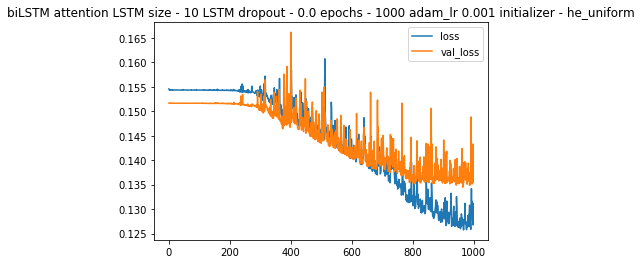

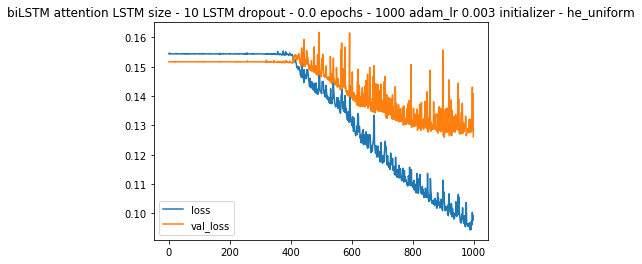

In [17]:
for i in range(len(adam_lr)):
    lr = adam_lr[i]
    for j in range(len(initializers)):
        initializer = initializers[j]
        print(f'adam_lr - {lr} initializer - {initializer}')

        optimizer = Adam(lr = lr)
        model = get_model_biLSTM_attention(initializer, LSTM_size)
        model.compile(optimizer = optimizer,
                     loss = 'mean_squared_error')
        # early_stopping = EarlyStopping(patience = 300)

        folder_path = 'Kka2/model_and_checkpoints/' + f'biLSTM attention LSTM size - {LSTM_size} epochs - {n_epochs} adam_lr {lr} initializer - {initializer}'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        checkpointing = ModelCheckpoint(folder_path + '/weights.{epoch:02d}-{val_loss:.5f}.hdf5',
                               save_best_only = True)
        history = model.fit(X_train, y_train, validation_data = (X_val, y_val), 
                            batch_size = 512, epochs = n_epochs, verbose = 1,
                            callbacks = [checkpointing])

# save the model summary
#         model_json = model.to_json()
#         with open(folder_path + '.json', 'w') as file:
#             file.write(model_json)
# get the Pearson score
# y_pred = model.predict(X_test)
# y_pred = np.reshape(y_pred, (1094,))

# from scipy.stats import pearsonr, spearmanr
# pearson_score = pearsonr(y_test, y_pred)
# print(f'Pearson correlation - {pearson_score}')
# spearman_score = spearmanr(y_test, y_pred)
# print(f'Spearman correlation - {spearman_score}')

# import pickle
# pickle.dump(pearson_score, open(f'LSTM units - {LSTM_units} epochs - {n_epochs} adam_lr {adam_lr} v3.p', 'wb'))

# visualize the training and validation loss curves
        plt.figure()
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epoch = np.arange(n_epochs)
        plt.plot(epoch, loss, label = 'loss')
        plt.plot(epoch, val_loss, label = 'val_loss')
        plt.title(f'biLSTM attention LSTM size - {LSTM_size} LSTM dropout - {LSTM_dropout} epochs - {n_epochs} adam_lr {lr} initializer - {initializer}')
        plt.legend()
        plt.savefig('Kka2/' + f'biLSTM attention LSTM size - {LSTM_size} LSTM dropout - {LSTM_dropout} epochs - {n_epochs} adam_lr {lr} initializer - {initializer}' + '.png')

In [ ]:
# get the Pearson score for biLSTM attention
model = get_model_biLSTM_attention(initializer, LSTM_size)
model.load_weights(folder_path + '/weights.905-0.12600.hdf5')

y_pred = model.predict(X_val)
y_pred = np.reshape(y_pred, (-1,))

from scipy.stats import pearsonr, spearmanr
pearson_score = pearsonr(y_val, y_pred)
print(f'Pearson correlation - {pearson_score}')

In [27]:
model.save(folder_path + ' full model.hdf5')
with open(folder_path + ' full model.json', 'w') as file:
    file.write(model.to_json())

In [22]:
# get Pearson score for LSTM attention
model = get_model_LSTM_attention('he_uniform', LSTM_size)
model.load_weights('Kka2/model_and_checkpoints/biLSTM attention LSTM size - 10 epochs - 1000 adam_lr 0.003 initializer - he_uniform/' + 'weights.905-0.12600.hdf5')

y_pred = model.predict(X_val)
y_pred = np.reshape(y_pred, (-1,))

from scipy.stats import pearsonr, spearmanr
pearson_score = pearsonr(y_val, y_pred)
print(f'Pearson correlation - {pearson_score}')

Pearson correlation - (0.42184031139093203, 5.767618886509837e-17)


In [ ]:
# envision
0.47